In [4]:
import pandas as pd
import numpy as np

In [5]:
YK_label = pd.read_excel('../data/YK_LABEL.xlsx')
YK_data = pd.read_csv('../data/YK_training_ULT.csv')

In [6]:
#Looking at the shape of each dataset
print(YK_data.shape)

(69577, 1076)


In [7]:
#Function to drop columns (tests) in the raw data file which are NOT tests (i.e metadata like start time, lot number etc)
def test_only(datafile,labelfile):
    keys = list(labelfile['Name'])
    df = datafile[keys]
    return df

In [8]:
#Applying the functions to file 
YK_dropped = test_only(YK_data,YK_label)
#Checking the shape and how the data looks like
print(YK_dropped.shape)
print(YK_dropped.head())

(69577, 1039)
   temperature  Device_Test_Time  \
0         25.0           22332.0   
1         25.0           11976.0   
2         25.0           11920.0   
3         25.0            9224.0   
4         25.0           11936.0   

   otp_read_line0_stdf_:ULT_Chksum@ULT_Chksum[1]  Part_Id  \
0                                            NaN      1.0   
1                                            NaN      2.0   
2                                            NaN      3.0   
3                                            NaN      4.0   
4                                            NaN      5.0   

   otp_read_blank:Functional[1]  g2bist_efuse_blank_read_f_:Functional[1]  \
0                           NaN                                       NaN   
1                           NaN                                       NaN   
2                           NaN                                       NaN   
3                           NaN                                       NaN   
4                

## Identifying the columns with less than 50,000 data points
For these columns, there are 2 ways of dealing with them - (i) to drop these columns completely and (ii) to replace the missing values

In [9]:
def identify_col(df):
    null_perCol = df.isnull().sum()
    insuff_col = {}
    for index in range(len(null_perCol)):
        if(df.shape[0]-null_perCol[index]<50000):
            insuff_col[null_perCol.index[index]] = null_perCol[index]
    return list(insuff_col.keys())

In [10]:
#Applying the above function to set of data
YK_less50000 = identify_col(YK_dropped)
#Printing to see the tests (columns) that has <50,000 data points 
print("For YK data: ",YK_less50000)

For YK data:  ['otp_read_line0_stdf_:ULT_Chksum@ULT_Chksum[1]', 'otp_read_blank:Functional[1]', 'g2bist_efuse_blank_read_f_:Functional[1]', 'tdf_50k_1_f_:Functional[1]', 'tdf_50k_2_f_:Functional[1]', 'stf_50k_1_f_:Functional[1]', 'tdf_50k_6_f_:Functional[1]', 'tdf_50k_3_f_:Functional[1]', 'g2bist_mac_256mhz_max_:Functional[1]', 'g2bist_mac_256mhz_min_:Functional[1]', 'sbist_soc_256mhz_max_:Functional[1]', 'sbist_soc_256mhz_min_:Functional[1]', 'stf_50k_2_f_:Functional[1]', 'stf_50k_3_f_:Functional[1]', 'stf_50k_4_f_:Functional[1]', 'tdf_50k_4_f_:Functional[1]', 'tdf_50k_5_f_:Functional[1]', 'tdf_50k_9_f_:Functional[1]', 'tdf_50k_8_f_:Functional[1]', 'tdf_90k_1_f_:Functional[1]', 'otp_read_line0_sva_f_:Functional[1]', 'tdf_50k_7_f_:Functional[1]', 'tdf_50k_10_f_:Functional[1]', 'tdf_90k_2_f_:Functional[1]', 'tdf_90k_3_f_:Functional[1]', 'tdf_90k_4_f_:Functional[1]', 'tdf_90k_5_f_:Functional[1]', 'tdf_90k_6_f_:Functional[1]', 'tdf_90k_7_f_:Functional[1]', 'tdf_90k_8_f_:Functional[1]', 't

## Identify the applicable columns (i.e those with a label)
Those without a label will be dropped, since there will not be any response variable (distribution of categories) to predict the predictor variable (data points)

In [11]:
#Function to find out non applicable rows (no distribution, not part of training data)
def non_applicable (df_label):
    null_rowsLabel = df_label[df_label['Distribution Type'].isnull()]
    null_rowsLabel = list(null_rowsLabel['Name'])
    return null_rowsLabel

In [12]:
#Applying the above function to set of data
YK_non_applicable = non_applicable(YK_label)
#Printing the tests (columns) to see which tests do not have a distribution (i.e not applicable)
print(YK_non_applicable)
print(len(YK_non_applicable))

['otp_read_line0_stdf_:ULT_Chksum@ULT_Chksum[1]', 'otp_read_blank:Functional[1]', 'tdf_50k_1_f_:Functional[1]', 'tdf_50k_4_f_:Functional[1]', 'tdf_50k_9_f_:Functional[1]', 'tdf_50k_8_f_:Functional[1]', 'otp_read_line0_sva_f_:Functional[1]', 'tdf_50k_10_f_:Functional[1]', 'tdf_90k_2_f_:Functional[1]', 'tdf_90k_7_f_:Functional[1]', 'tdf_90k_8_f_:Functional[1]', 'tdf_90k_10_f_:Functional[1]', 'tdf_90k_11_f_:Functional[1]', 'tdf_90k_15_f_:Functional[1]']
14


## Identifying the applicable columns with <50,000 data points
These columns could either be dropped, or replace with data, depending on the nature of the columns/test itself.

In [13]:
#Function to find out the specific columns which we will need to inspect
def col_inspect(insuff_col_keys,null_rowsLabel):
    col_to_inspect = [i for i in insuff_col_keys if i not in null_rowsLabel]
    return col_to_inspect

The code above is to find the columns with <50,000 points, yet are applicable (i.e there is a label). This means that these are the columns we would need to inspect and do some pre processing to them so that there is sufficient data points (50,000) to train these test.

In [14]:
#Applying the above function to set of data
YK_inspect = col_inspect(YK_less50000,YK_non_applicable)
#Printing to see the cols to inspect
print(YK_inspect)

['g2bist_efuse_blank_read_f_:Functional[1]', 'tdf_50k_2_f_:Functional[1]', 'stf_50k_1_f_:Functional[1]', 'tdf_50k_6_f_:Functional[1]', 'tdf_50k_3_f_:Functional[1]', 'g2bist_mac_256mhz_max_:Functional[1]', 'g2bist_mac_256mhz_min_:Functional[1]', 'sbist_soc_256mhz_max_:Functional[1]', 'sbist_soc_256mhz_min_:Functional[1]', 'stf_50k_2_f_:Functional[1]', 'stf_50k_3_f_:Functional[1]', 'stf_50k_4_f_:Functional[1]', 'tdf_50k_5_f_:Functional[1]', 'tdf_90k_1_f_:Functional[1]', 'tdf_50k_7_f_:Functional[1]', 'tdf_90k_3_f_:Functional[1]', 'tdf_90k_4_f_:Functional[1]', 'tdf_90k_5_f_:Functional[1]', 'tdf_90k_6_f_:Functional[1]', 'tdf_90k_9_f_:Functional[1]', 'tdf_90k_12_f_:Functional[1]', 'tdf_90k_13_f_:Functional[1]', 'tdf_90k_14_f_:Functional[1]', 'tdf_90k_16_f_:Functional[1]', 'tdf_90k_17_f_:Functional[1]', 'tdf_90k_18_f_:Functional[1]']


## Replacing the missing values in these columns
Note that as shown by the printed output above, for YK data, all the columns to inspect (those applicable and with <50,000 data points), they are all functional tests. we would need to do another round of checks to find out the distributions (labels) of the tests above to ensure that the replacement of missing values does not affect the distribution. 

In [15]:
#Checking the distribution of the col shown above to inspect if there are really functional!
check_labels = YK_label[YK_label['Name'].isin(YK_inspect)]
check_labels['Distribution Type'].value_counts()

functional    26
Name: Distribution Type, dtype: int64

Since the above columns are all functional, we replace the missing values with 0 or 1 (since it will not affect the distribution)

In [16]:
#Function to replace the missing values with 0 and 1
def replace_func(df_dropped,df_col_inspect,non_applicable):
    pd.options.mode.chained_assignment = None 
    #Replacing missing 0 and 1 values
    for cols in df_col_inspect:
        null_count = df_dropped[cols].isnull().sum()
        df_dropped[cols] = df_dropped[cols].fillna(pd.Series(np.random.choice([0,-1],size=null_count)))
    #Dropping the tests with no distributions (not applicable)
    df = df_dropped.drop(columns=non_applicable)
    return df

In [17]:
#Applying it on data sets
YK_replace = replace_func(YK_dropped,YK_inspect,YK_non_applicable)

In [18]:
#Check if everything is replaced correctly (no more null values for the columns with <50000) data points
def check_nonull(df):
    null_perCol = df.isnull().sum()
    insuff_col = {}
    for index in range(len(null_perCol)):
        if(df.shape[0]-null_perCol[index]<50000):
            insuff_col[null_perCol.index[index]] = null_perCol[index]
    print(insuff_col)
    print(len(insuff_col))

In [19]:
check_nonull(YK_replace)

{}
0


## Sampling data
For columns with >50000 data points, systematic sampling + randomised sampling will be done. In intervals of 2, data points will be selected and the leftover points will be selected by random

In [20]:
#Converting systematic sampling (FOR FLOATS) to a function
def float_sample_2(population,sample_size):
    base_interval = len(population) // sample_size
    remainder = len(population)%sample_size
    #indices = []
    indices = {}
    #Add in min and max points in array
    min_index = population.argmin()
    max_index = population.argmax()
    indices[0] = min_index
    indices[1] = max_index
    start_index = np.random.randint(0,base_interval)
    for i in range(2,sample_size):
        interval = base_interval + 1 if i < remainder else base_interval
        #print("Interval is: ", interval)
        index = (start_index + i * interval) % len(population)
        #print("Index is: ",index)
        #indices.append(index)
        indices[i] = index
    #print("The dict is: ",indices)
    unique_indices = list(indices.values())
    unique_indices = [*set(unique_indices)]
    systematic_sample = population[unique_indices]
    #print("Before delete")
    #print("systematic_sample: ",systematic_sample)
    population = np.delete(population,unique_indices)
    #print("After delete")
    if len(systematic_sample) < sample_size:
        remaining_samples = sample_size - len(systematic_sample)
        remaining_indices = np.random.choice(len(population),remaining_samples,replace=False)
        systematic_sample = np.concatenate((systematic_sample,population[remaining_indices]))
    return systematic_sample

In [21]:
#Function to apply the systematic sampling for the function 
def apply_sampling(df):
    new_df = pd.DataFrame()
    for colName,colData in df.items():
        data = df.dropna(subset=colName)
        newCol = list(data[colName])
        newCol = np.array(newCol)
        newCol = pd.Series(float_sample_2(newCol,50000))
        #Can only concat after sampling!!
        new_df = pd.concat([new_df,newCol.rename(colName)],axis=1)
    return new_df

In [ ]:
#Apply sampling functions to datasets
YK_data_final = apply_sampling(YK_replace)

## Normalisation of the data 
Data are normalised using the min max module from scikit learn. This will compress the data points from 0 to 1 but will not change its distribution.

In [23]:
#Import relevant packages 
from sklearn import preprocessing
min_max = preprocessing.MinMaxScaler()

In [24]:
#Function to normalise all the columns in a dataframe
def normalise(df):
    final_df = pd.DataFrame()
    for colName,colData in df.items():
        c_scaled = min_max.fit_transform(df[[colName]])
        c_scaled = pd.Series(c_scaled.ravel())
        final_df = pd.concat([final_df,c_scaled.rename(colName)],axis=1)
    return final_df

In [25]:
#Applying it to the datasets
YK_data_final = normalise(YK_data_final)
#Printing to see the shape of the data
print(YK_data_final.shape)
print(YK_data_final.head())

(50000, 1025)
   temperature  Device_Test_Time   Part_Id  \
0          0.0          0.399193  0.000000   
1          0.0          0.397441  0.000206   
2          0.0          0.396992  0.000308   
3          0.0          0.586461  0.000411   
4          0.0          0.586461  0.000514   

   g2bist_efuse_blank_read_f_:Functional[1]  tdf_50k_2_f_:Functional[1]  \
0                                       1.0                         1.0   
1                                       0.0                         0.0   
2                                       1.0                         1.0   
3                                       0.0                         0.0   
4                                       0.0                         1.0   

   stf_50k_1_f_:Functional[1]  write_dro_sidd:Functional[1]  \
0                         0.0                           0.0   
1                         1.0                           0.0   
2                         0.0                           0.0   
3     

## Pre-processing the label file
The codes above are for the raw data (The data points for each test).The labels under the label file (YK_label) are the categorical variables denoting the distribution of each test (each column in the raw data file). There are 6 labels/distribution categories - outlier, normal, longtail, functional, discrete and bimodal. Now we will process the label files and identify those rows where there are no distribution (not applicable) and proceed to drop them. 

In [26]:
#Function to faciliate the dropping of the null rows in labels file
def drop_null_labels(label_df,not_applicable):
    df = label_df.drop(label_df[label_df.Name.isin(not_applicable)].index)
    return df

In [27]:
#Applying it to set of data
YK_label_final = drop_null_labels(YK_label,YK_non_applicable)

Now for visualisation, we will concatenate the dataframes together, such that we will have 2 columns, 'Name' and 'Distribution Type' for the tests and distribution respectively. We will use the below 2 functions to facilitate the concatenation.

In [28]:
#Function to concat the dataframes (raw data and the name of the tests) -> row format. i.e 2 columns: data, name
def concat_xy(df):
    cols = ['Data','Name']
    concat_df = pd.DataFrame(columns=cols,index=range(df.shape[1]))
    index = 0
    for colName, colData in df.items():
        #variable index is to retrieve the index of the columns in YK raw (final_df)
        vals = np.array(colData.values)
        concat_df.loc[index].Data = vals
        concat_df.loc[index].Name = colName
        index+=1
    return concat_df

In [29]:
#Applying it to our dataset
YK_testname_data = concat_xy(YK_data_final)
#See how it looks like
print(YK_testname_data.head())

                                                Data  \
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...   
1  [0.399193055385744, 0.39744059991033953, 0.396...   
2  [0.0, 0.0002055076037813399, 0.000308261405672...   
3  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...   
4  [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...   

                                       Name  
0                               temperature  
1                          Device_Test_Time  
2                                   Part_Id  
3  g2bist_efuse_blank_read_f_:Functional[1]  
4                tdf_50k_2_f_:Functional[1]  


In [30]:
#Function concatenating the Y (distribution) with the raw data (X) -> dataframe passed in is the label final! concat_df is testname_data
def model_xy(label_df,concat_df):
    dist_labels = label_df[['Distribution Type','Name']]
    model_df = pd.merge(concat_df,dist_labels,on='Name')
    model_df_xy = model_df[['Data','Distribution Type']]
    return model_df_xy

In [31]:
#Applying it to the data sets
YK_model = model_xy(YK_label_final,YK_testname_data)
print(YK_model.shape)
#Visualising how it looks like
print(YK_model.head())

(1025, 2)
                                                Data Distribution Type
0  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...        functional
1  [0.399193055385744, 0.39744059991033953, 0.396...          longtail
2  [0.0, 0.0002055076037813399, 0.000308261405672...          longtail
3  [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...        functional
4  [1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...        functional


## LUNA
Separate distribution type (target labels) into two distinct group. Aim is to group outlier and longtail distributions together, for binary classification task.

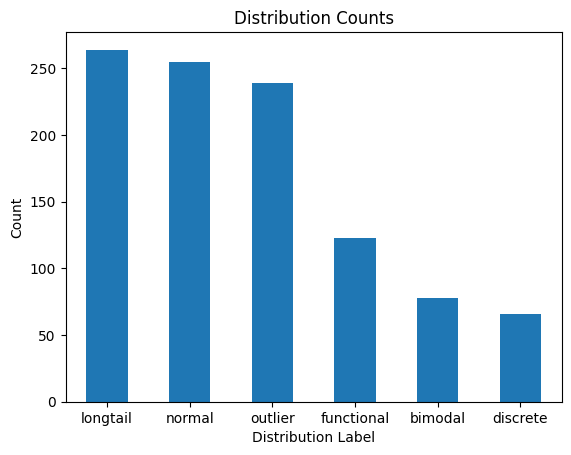

In [38]:
distribution_counts = YK_model['Distribution Type'].value_counts()

import matplotlib.pyplot as plt

distribution_counts.plot(kind='bar')
plt.title('Distribution Counts')
plt.xlabel('Distribution Label')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()


In [116]:
# Function to relabel target variable into binary values, where outlier and longtail are grouped together

def relabel_data(original_label):
    if original_label in ['outlier', 'longtail']:  
        return 'Outlier/Longtail'
    else:
        return 'Other'

In [117]:
# New column added with the updated labels 

YK_model['new_label'] = YK_model['Distribution Type'].apply(relabel_data)

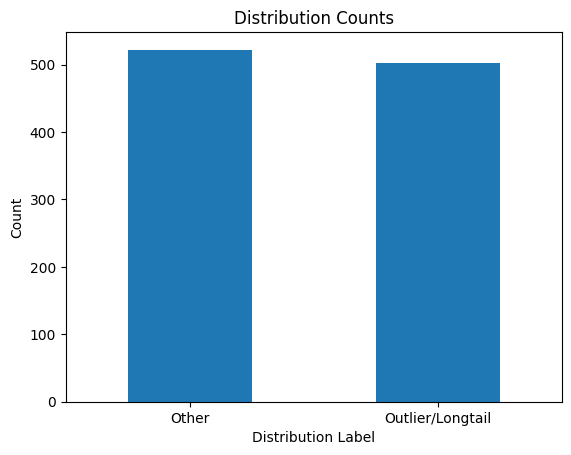

In [118]:
binary_distribution_counts = YK_model['new_label'].value_counts()

binary_distribution_counts.plot(kind='bar')
plt.title('Distribution Counts')
plt.xlabel('Distribution Label')
plt.xticks(rotation=0)
plt.ylabel('Count')
plt.show()

## Reducing feature space 
Propose to try different methods for reducing features:
1. PCA dimensionality reduction
2. Clustering using Kmeans, then sample from every cluster
3. Stratified sampling with binning

Propose to engineer new features (additional) regardless of method chosen above:
1. Mean/median/mode
2. Z-score and IQR labelling 
3. Skewness and kurtosis

At the end, to find out if:
1. Is converting feature space to just the additional features (solely statistical parameters or outlier statistics) without the test data better?
2. For blunderbuss with 6 different classes, how to balance data set? (previous method was trimming)
3. Is model necessary? Or is pipeline of statisical analysis enough to classify the exact distribution?
4. Is there a way to standardize the labelling of distribution? (currently based on 3 employees' judgements) -> this is to prevent model from being trained just on their judgements, or even worse just on one of their judgements

In [119]:
binary_df = YK_model[['Data','new_label']]
binary_df.shape
#1025 data points (tests), each with 50000 features (test values)

(1025, 2)

In [120]:
binary_df.head()

,Data,new_label
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Other
1,"[0.399193055385744, 0.39744059991033953, 0.396...",Outlier/Longtail
2,"[0.0, 0.0002055076037813399, 0.000308261405672...",Outlier/Longtail
3,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, ...",Other
4,"[1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, ...",Other


In [121]:
# Function to bin data based on quantiles
def bin_data(df, num_bins):
    new_df = []
    for index, row in df.iterrows():
        values = row['Data']
        label = row['new_label']

        if len(pd.unique(values)) <= 2:
            # Directly use the binary values since not enough unique values to granularly separate into bins
            binned_values = values.astype(int)
        else:
            binned_values = pd.qcut(values, num_bins, labels=False, duplicates='drop')

        new_df.append({
        'data': values,
        'bin': binned_values,
        'label': label
        })
    return pd.DataFrame(new_df)

In [122]:
binned_df = bin_data(binary_df, 5000)

In [168]:
binned_df[binned_df['label'] != 'Other']

,data,bin,label
1,"[0.399193055385744, 0.39744059991033953, 0.396...","(65, 64, 63, 1086, 1086, 1086, 1209, 1209, 120...",Outlier/Longtail
2,"[0.0, 0.0002055076037813399, 0.000308261405672...","(0, 3, 5, 7, 9, 11, 13, 15, 18, 20, 22, 24, 26...",Outlier/Longtail
84,"[0.3804993788936786, 0.3871456870753418, 0.428...","(1870, 2025, 3113, 4009, 2263, 2854, 4987, 182...",Outlier/Longtail
85,"[0.38633312616532045, 0.439285270354258, 0.468...","(1578, 2826, 3572, 3689, 2337, 2946, 4980, 179...",Outlier/Longtail
86,"[0.7492980162046248, 0.7903511002021304, 0.730...","(1377, 4484, 477, 3046, 4369, 373, 2418, 4319,...",Outlier/Longtail
...,...,...,...
983,"[0.3555555555555556, 0.3111111111111111, 0.377...","(12, 10, 13, 15, 13, 8, 16, 11, 12, 18, 7, 11,...",Outlier/Longtail
984,"[0.33890414229437726, 0.4501611555449443, 0.34...","(537, 1553, 627, 943, 420, 844, 1281, 1591, 50...",Outlier/Longtail
985,"[0.512159603902723, 0.6807921945536624, 0.5229...","(706, 1981, 785, 1324, 568, 829, 1796, 1954, 5...",Outlier/Longtail
986,"[0.4927363972530374, 0.6436872688853672, 0.506...","(663, 1911, 774, 1167, 550, 983, 1800, 1844, 6...",Outlier/Longtail


In [ ]:
def sample_from_bins(row, num_samples):
    data = row['data']
    bins = row['bin']
    
    data_array = np.array(data)
    bins_array = np.array(bins)
    
    unique_bins = np.unique(bins_array)
    
    sampled_data = []
    sampled_bins = []
    
    for b in unique_bins:
        bin_indices = np.where(bins_array == b)[0]
        if len(bin_indices) > 0:
            num_samples_per_bin = max(num_samples // len(unique_bins), 1)
            sampled_indices = np.random.choice(bin_indices, min(len(bin_indices), num_samples_per_bin), replace=False)
            sampled_data.extend(data_array[sampled_indices])
            sampled_bins.extend(bins_array[sampled_indices])
    
    # If the total number of sampled data points is less than num_samples, fill the remaining with data points
    if len(sampled_data) < num_samples:
        additional_samples = num_samples - len(sampled_data)
        additional_indices = np.random.choice(len(data_array), additional_samples, replace=False)
        sampled_data.extend(data_array[additional_indices])
        sampled_bins.extend(bins_array[additional_indices])
    
    return pd.Series({'data': sampled_data, 'bin': sampled_bins, 'label': row['label']})


In [133]:
# Stratified sampling by bins
def stratified_sampling(df, bin_col, sample_size):
    

    df[bin_col] = df[bin_col].apply(lambda x: tuple(x))
    num_bins = df[bin_col].nunique() #number of bins 
    samples_per_bin = sample_size // num_bins #number of data points to take from each bin

    df_sampled = df.groupby(bin_col, group_keys=False).apply(lambda x: x.sample(min(len(x), samples_per_bin)))
    return df_sampled

In [134]:
sample_size = 5000
sampled_df = stratified_sampling(binned_df, 'bin', sample_size)

In [154]:
len(binned_df['bin'][0])

50000

In [162]:
binned_df['bin']

0       (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1       (65, 64, 63, 1086, 1086, 1086, 1209, 1209, 120...
2       (0, 3, 5, 7, 9, 11, 13, 15, 18, 20, 22, 24, 26...
3       (1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, ...
4       (1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, ...
                              ...                        
1020    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1021    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1022    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1023    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1024    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
Name: bin, Length: 1025, dtype: object

In [167]:
sampled_df['bin']

965     (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1022    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
1024    (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
888     (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
453     (0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...
                              ...                        
659     (4969, 4431, 2293, 4670, 2197, 2750, 4460, 319...
577     (4972, 2068, 2157, 3815, 3114, 3223, 3300, 362...
860     (4986, 1551, 3094, 692, 3496, 3515, 405, 1735,...
613     (4995, 1638, 3961, 3581, 4653, 1125, 3631, 466...
612     (4998, 1540, 4315, 4821, 4849, 1058, 4910, 497...
Name: bin, Length: 914, dtype: object

In [166]:
len(sampled_df['bin'][965])

50000

In [145]:
sampled_df[0]

KeyError: 0

In [128]:
print(binned_df['bin'].apply(type).value_counts())

<class 'numpy.ndarray'>    1025
Name: bin, dtype: int64


In [ ]:
from sklearn.decomposition import PCA

#rows as chips and columns as tests
pca = PCA(n_components=5000)
reduced_data = pca.fit_transform(data)